In [1]:
import numpy
import torch
import matplotlib.pyplot as plt
%matplotlib inline


# E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. 
# Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

In [2]:
words = open('names.txt', 'r').read().splitlines()


In [3]:
g = torch.Generator().manual_seed(2147483647)
perm = torch.randperm(len(words), generator=g)

n = len(words)
n_train = int(0.8 * n)
n_dev = int(0.1 * n)

train_words = [words[i] for i in perm[:n_train]]
dev_words = [words[i] for i in perm[n_train:n_train + n_dev]]
test_words = [words[i] for i in perm[n_train + n_dev:]]

In [4]:
chars = sorted(list(set(''.join(words))))
ctoi = {c: i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
N = torch.zeros((27, 27), dtype=torch.int32)
itoc = {i: c for c, i in ctoi.items()}

In [5]:
import torch.nn.functional as F
# NN trigram model
def make_trigram_tensors(words_list):
    xs, ys = [], []
    for w in words_list:
        chs = list(f"..{w}.")
        for i in range(len(chs)-2):
            ix1, ix2, y1 = ctoi[chs[i]], ctoi[chs[i+1]], ctoi[chs[i+2]]
            xs.append([ix1, ix2])
            ys.append(y1)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    contexts = xs[:, 0] * 27 + xs[:, 1] # Index into a flatten 27*27 = 0,...,728 sequence of numbers.
    xenc = F.one_hot(contexts, num_classes=27*27).float()
    return xenc, ys

In [6]:
def train_nn(xenc, ys):
    num_examples = xenc.shape[0] # dim (num_examples, 729)
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((27*27, 27), generator=g, requires_grad=True) # dim (729, 27)
    for _ in range(300):
        logits = xenc @ W # (num_examples, 27)
        counts = logits.exp() # softmax step 1
        probs = counts / counts.sum(1, keepdim=True) # softmax step 2
        loss = -probs[torch.arange(num_examples), ys].log().mean() + 0.01*(W**2).mean() # nll = (-1/n) * sum(log(probs)) + regularization

        print(f"Loss: {loss.item()}")

        # update
        W.grad = None    
        loss.backward()

        W.data += -150 * W.grad
    return W

In [ ]:
xenc, ys = make_trigram_tensors(train_words)
W = train_nn(xenc, ys)
with torch.no_grad():
    x_dev, y_dev = make_trigram_tensors(dev_words)
    logits = x_dev @ W
    dev_loss_nn = torch.nn.functional.cross_entropy(logits, y_dev)

    x_test, y_test = make_trigram_tensors(test_words)
    logits = x_test @ W
    test_loss_nn = torch.nn.functional.cross_entropy(logits, y_test)

    print(f"{test_loss_nn=}")
    print(f"{dev_loss_nn=}")

Loss: 3.802690267562866
Loss: 3.4846155643463135
Loss: 3.339570999145508
Loss: 3.2287955284118652
Loss: 3.1545755863189697
Loss: 3.069249153137207
Loss: 3.020155906677246
Loss: 2.9616687297821045
Loss: 2.9330220222473145
Loss: 2.8769516944885254
Loss: 2.851630210876465
Loss: 2.817028284072876
Loss: 2.8071608543395996
Loss: 2.761727809906006
Loss: 2.7455339431762695
Loss: 2.72540283203125
Loss: 2.7254443168640137
Loss: 2.6847000122070312
Loss: 2.6730480194091797
Loss: 2.6602606773376465
Loss: 2.664473056793213
Loss: 2.629054069519043
Loss: 2.6218535900115967
Loss: 2.6115405559539795
Loss: 2.619166851043701
Loss: 2.5854108333587646
Loss: 2.5799949169158936
Loss: 2.572547197341919
Loss: 2.581888198852539
Loss: 2.5506317615509033
Loss: 2.547349691390991
Loss: 2.5410447120666504
Loss: 2.552110433578491
Loss: 2.5216636657714844
Loss: 2.519300937652588
Loss: 2.5145440101623535
Loss: 2.526540517807007
Loss: 2.4975130558013916
Loss: 2.4963760375976562
Loss: 2.492279529571533
Loss: 2.50529241561

In [ ]:
# Sampling
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out, ix1, ix2 = [] ,0, 0
  while True:
    ctx = torch.tensor([ix1 * 27 + ix2])
    xenc = F.one_hot(ctx, num_classes=27*27).float()
    logits = xenc @ W # prediction for log counts
    counts = logits.exp() # counts
    p = counts / counts.sum(1, keepdim=True) # probabilities for next char by the model
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itoc[ix])
    if ix == 0:
      break
    ix1, ix2 = ix2, ix
  print(''.join(out))




dexzdfzjglkuriana.
kaydemmilistona.
nylanak.
ka.
da.


In [ ]:
# Trigram Laplace Counting Model
N = torch.zeros((27, 27, 27), dtype=torch.int32)
for w in train_words:
    chs = list(f"..{w}.")
    for i in range(len(chs)-2):
        ix1, ix2, y1 = ctoi[chs[i]], ctoi[chs[i+1]], ctoi[chs[i+2]]
        N[ix1, ix2, y1]+=1

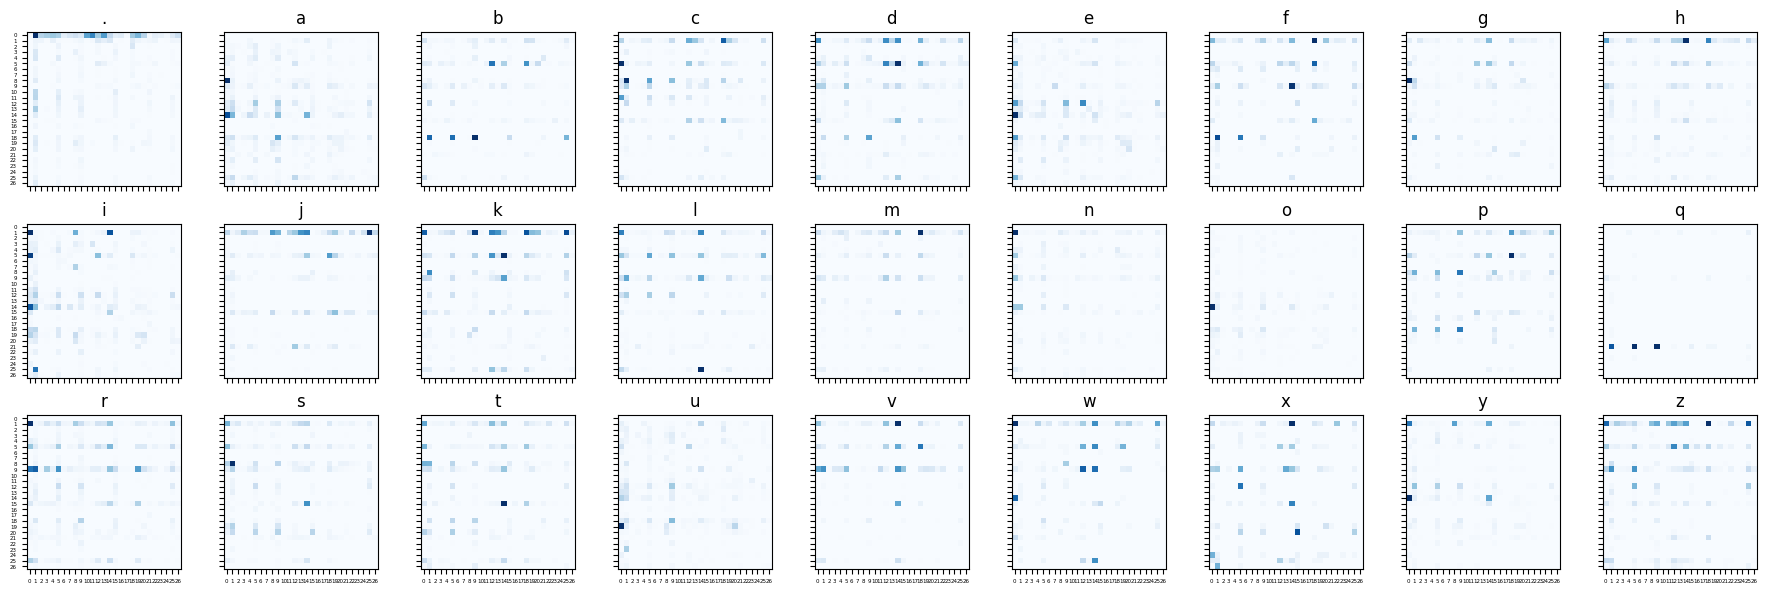

In [ ]:
fig, axes = plt.subplots(3, 9, figsize=(18, 6), sharex=True, sharey=True)
for idx, ax in enumerate(axes.flat):
    if idx >= 27:
        ax.axis("off")
        continue
    mat = N[idx].float()
    ax.imshow(mat, cmap="Blues")
    ax.set_title(itoc[idx])
    ax.set_xticks(range(27))
    ax.set_yticks(range(27))
    ax.tick_params(labelsize=4)
plt.tight_layout()

In [ ]:
P = (N+1).float() # laplace smoothing
P /= P.sum(2, keepdim=True)

In [ ]:
log_likelihood = 0.0
n = 0

for w in train_words:
    chs = list(f"..{w}.")
    for i in range(len(chs)-2):
        ix1, ix2, y1 = ctoi[chs[i]], ctoi[chs[i+1]], ctoi[chs[i+2]]
        prob = P[ix1, ix2, y1]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1

nll = -log_likelihood/n
print(f"{nll=}")

nll=tensor(2.2147)


In [ ]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix1, ix2 = 0, 0
  while True:
    p = P[ix1, ix2]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itoc[ix])
    if ix == 0:
      break
    ix1, ix2 = ix2, ix
  print(''.join(out))

ce.
bra.
jalius.
ilaziandrevonimilea.
nylanak.


In [ ]:
def trigram_nll(words_list, probs_table):
    log_likelihood, n = 0.0, 0
    for w in words_list:
        chs = list(f"..{w}.")
        for i in range(len(chs) - 2):
            ix1, ix2, ix3 = ctoi[chs[i]], ctoi[chs[i+1]], ctoi[chs[i+2]]
            log_likelihood += torch.log(probs_table[ix1,ix2,ix3])
            n+=1
    return -log_likelihood/n

In [ ]:
dev_loss_count = trigram_nll(dev_words, P)
test_loss_count = trigram_nll(test_words, P)